# makemore: part 3

# Setup

In [1]:
import torch
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
data = Path('../data/')

torch.save(Xtr, data/'x_train')
torch.save(Ytr, data/'y_train')

torch.save(Xdev, data/'x_dev')
torch.save(Ydev, data/'y_dev')

torch.save(Xte, data/'x_test')
torch.save(Yte, data/'y_test')

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

def init_net(n_embd=10, n_hidden=200, block_size=3):
  global vocab_size

  g = torch.Generator().manual_seed(2147483647) # for reproducibility
  C  = torch.randn((vocab_size, n_embd),            generator=g)
  W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
  b1 = torch.randn(n_hidden,                        generator=g)
  W2 = torch.randn((n_hidden, vocab_size),          generator=g)
  b2 = torch.randn(vocab_size,                      generator=g)

  parameters = [C, W1, b1, W2, b2]
  print(sum(p.nelement() for p in parameters)) # number of parameters in total
  for p in parameters:
    p.requires_grad = True

  return parameters, g

(C,W1,b1,W2,b2), g = init_net()


11897


In [7]:

def training_loop(max_steps, batch_size=32):
  global h
  global hpreact
  global logits
  lossi = []
  parameters = [C,W1,b1,W2,b2]

  for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  return lossi
    

In [8]:
lossi = training_loop(50000)

      0/  50000: 27.8817
  10000/  50000: 2.7667
  20000/  50000: 2.6773
  30000/  50000: 2.7836
  40000/  50000: 2.0416


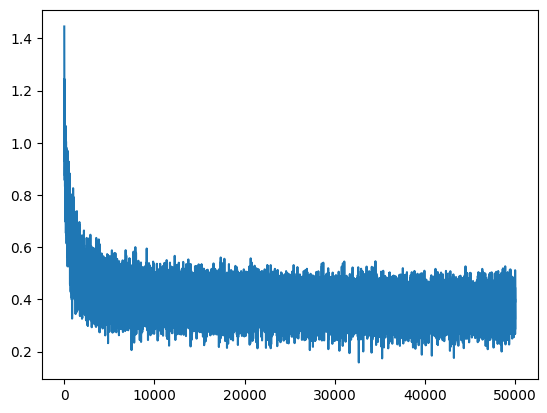

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, y) # loss function
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.330617666244507
val 2.354438304901123


# Initialization

The initial loss is way to high. Since the model does not know anything about character probabilities (and is initialized randomly), it should assign equal probability to each character.


## Logits


- Run Training loop, break after first iteration
  - Logits take on extreme values, resulting in high loss


In [11]:
(C,W1,b1,W2,b2), g = init_net()

lossi = training_loop(1)

11897
      0/      1: 27.8817


In [12]:
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

- Scale down W2, set b2 to zero
  - output should be more uniform


In [13]:
(C,W1,b1,W2,b2), g = init_net()

b2.data *= 0
W2.data *= .01

lossi = training_loop(1)
logits[0]

11897
      0/      1: 3.3221


tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

- Run training with new initialization
  - actual optimization starts right away
  - loss should be better (because of more effective training steps)

In [14]:
(C,W1,b1,W2,b2), g = init_net()

b2.data *= 0
W2.data *= .01

lossi = training_loop(50000)

split_loss('train')
split_loss('val')

11897
      0/  50000: 3.3221
  10000/  50000: 2.1900
  20000/  50000: 2.4196
  30000/  50000: 2.6067
  40000/  50000: 2.0601
train 2.2071497440338135
val 2.2513182163238525


## Tanh activations

### In last layer (h)

Lots of activations are $|1|$.
- Visualize by putting all activations into a histogram


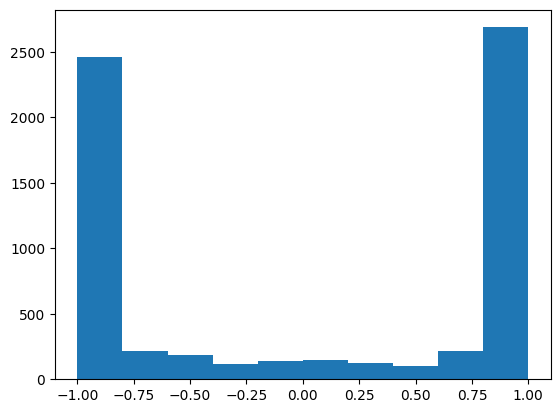

In [15]:
plt.hist(h.flatten().detach().numpy());

- Do the same to hpreact (activations from first layer)
  - Should be much better centered


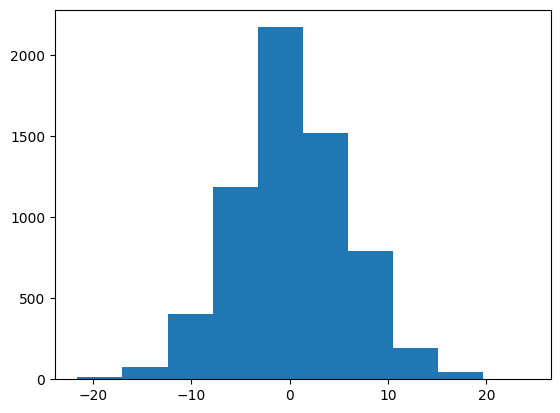

In [16]:
plt.hist(hpreact.flatten().detach().numpy());


Tanh of $|1|$ is problematic because it gives zero gradient, killing the backpropagation at this point.
Another visualization:
- Visualize booolean mask of h with cutoff at $.99$
  - imshow is white when True is plotted

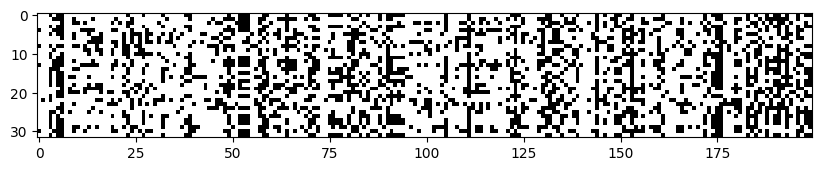

In [17]:
too_high = h.detach().numpy()>.99

fig,ax = plt.subplots(figsize=(10,5))
ax.imshow(too_high, cmap='Greys')
plt.show()

### In first layer (hpreact) 

Values of hpreact are nicely centered around $0$, but their variance is too large. Fix that by adjusting the weights of W1 and b1 during initialization:

- multiply b1 by $0.01$, W1 by $0.1$ (then $0.2$)
- re-plot the histograms and 'qr code'
- re-run training (after fresh initialization)
  - should improve loss again

In [18]:
(C,W1,b1,W2,b2), g = init_net()

W1.data *= .2
b1.data *= 0.01
b2.data *= 0
W2.data *= .01

lossi = training_loop(50000)

split_loss('train')
split_loss('val')

11897
      0/  50000: 3.3135
  10000/  50000: 2.1648
  20000/  50000: 2.3061
  30000/  50000: 2.4541
  40000/  50000: 1.9787
train 2.1464035511016846
val 2.1903910636901855


# Kaiming Init

- Draw randomn 1000x10 x, 10x200 w
- multiply = y


In [19]:
x = torch.randn((1000,10))
W = torch.randn((10,200))

y = x @ W
y.shape

torch.Size([1000, 200])

- show mean,std of x and y


In [23]:
print('x: ', x.mean().item(), x.std().item())
print('y: ', y.mean().item(), y.std().item())

x:  8.383579552173615e-05 0.9929354190826416
y:  0.0003739834646694362 3.1495330333709717


- plot x and y
- Mean should stay the same, but standard deviations increases by a lot

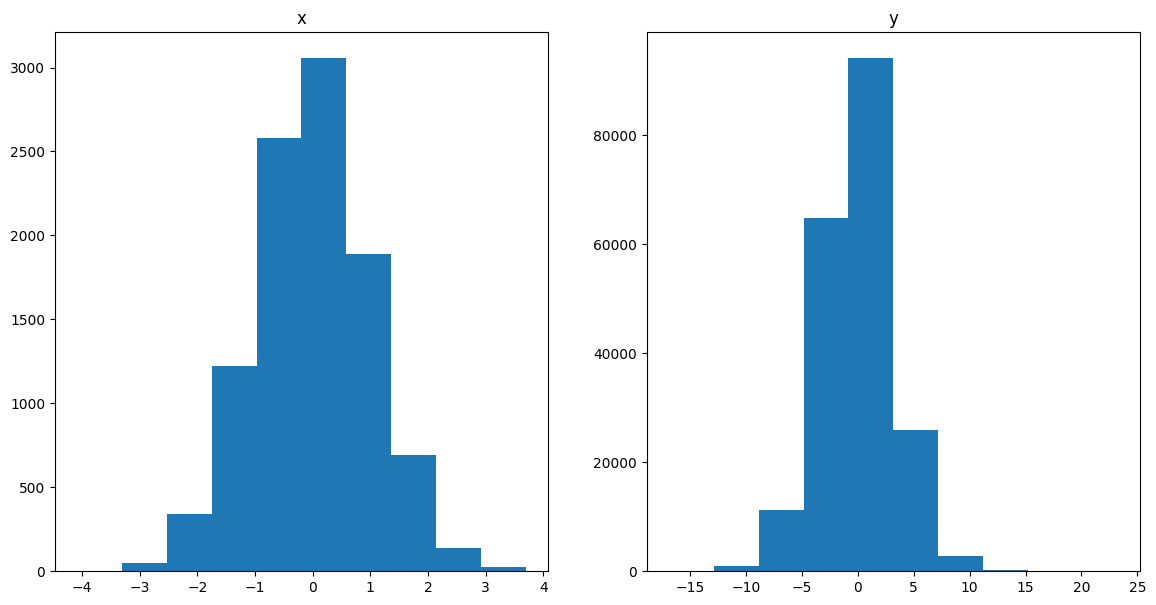

In [27]:
fig, (l,r) = plt.subplots(ncols=2, figsize=(14,7))

l.hist(x.flatten())
l.set_title('x')

r.hist(y.flatten())
r.set_title('y')

plt.show()

- increasing scale in W increases std of y (and vice versa)

In [29]:
x = torch.randn((1000,10))
W_large = torch.randn((10,200)) * 10
W_small = torch.randn((10,200)) * .1 

y_large = x @ W_large
y_small = x @ W_small

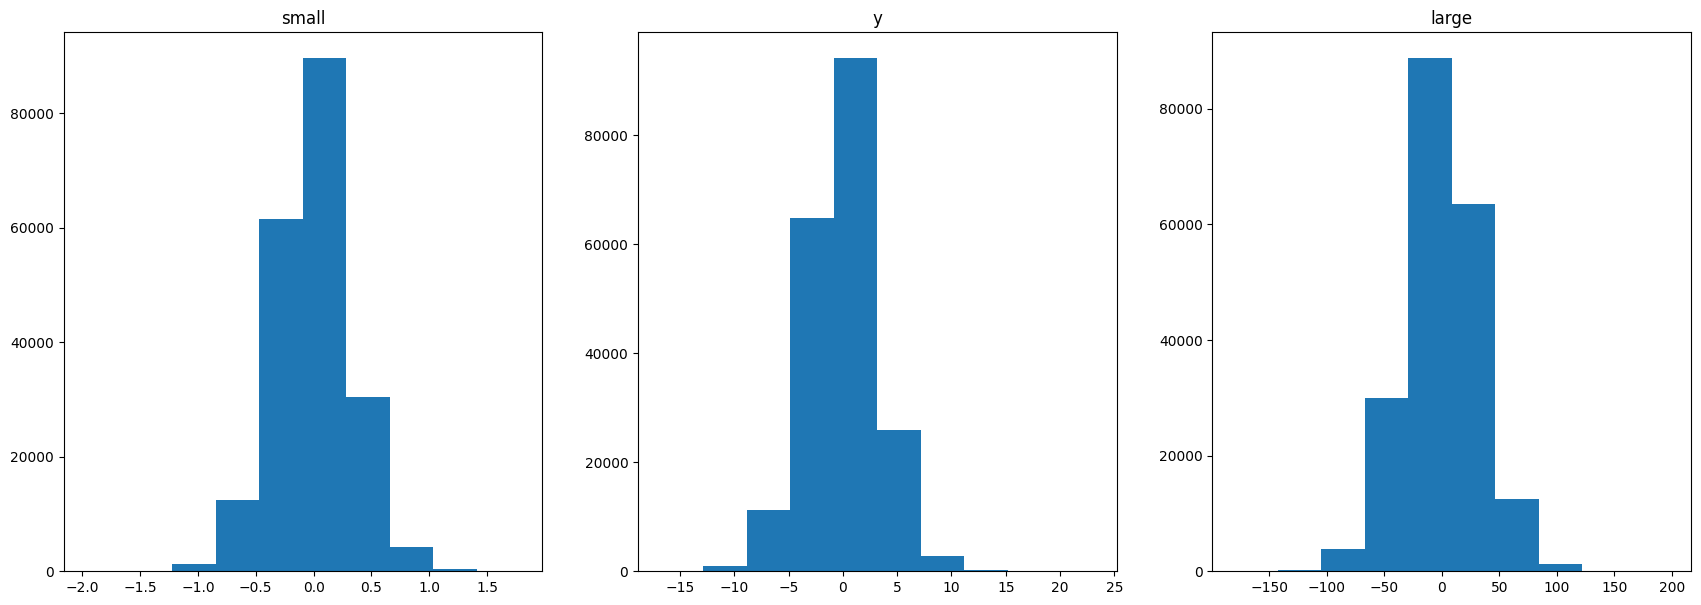

In [31]:
fig, (l,m,r) = plt.subplots(ncols=3, figsize=(21,7))

l.hist(y_small.flatten())
l.set_title('small')

m.hist(y.flatten())
m.set_title('y')

r.hist(y_large.flatten())
r.set_title('large')

plt.show()

- what is the optimal factor to use?
  - 1 / sqrt(fan_in) --> input size (10)


- examined by Kaiming et. al
- pytorch also has this at torch.nn.init.kaiming_normal_
  - decrease because of variance
  - increase because squashing -> "gain"
  - different non-linearities use different gains (see [pytorch doc site](https://pytorch.org/docs/stable/nn.init.html))
- compute W1 scale by hand (~.304)

In [37]:
tanh_gain = 5/3
init_factor = tanh_gain * 30 ** (-.5)
init_factor

0.3042903097250923

- rerun training
  - result should be roughly the same, but this time without magic constants

In [38]:
(C,W1,b1,W2,b2), g = init_net()

W1.data *= init_factor
b1.data *= 0.01
b2.data *= 0
W2.data *= .01

lossi = training_loop(50000)

split_loss('train')
split_loss('val')

11897
      0/  50000: 3.3179
  10000/  50000: 2.1910
  20000/  50000: 2.3270
  30000/  50000: 2.5396
  40000/  50000: 1.9468
train 2.151510715484619
val 2.198307752609253


# Batch Normalization

- Basic idea: standardize pre-activations
- hpreact: substract mean, divide by std (of the batch)
- Problem with having that directly in the training loop:
  - standardized should only be at initialization
  - nn should be able to scale and move the distribution
- Introduce two more parameters
  - bn_gain, bn_bias (ones, zeros)
  - learnable
- re-run training loop
  - result should be roughly the same

In [42]:
hpreact.mean(dim=0, keepdim=True).shape

torch.Size([1, 200])

In [56]:
(C,W1,b1,W2,b2), g = init_net()

W1.data *= init_factor
b1.data *= 0.01
b2.data *= 0
W2.data *= .01
bn_gain = torch.ones((1, 200), requires_grad=True)
bn_bias = torch.zeros((1, 200), requires_grad=True)


lossi = []
parameters = [C,W1,b1,W2,b2, bn_gain, bn_bias]
max_steps = 50000
batch_size = 32

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    ########## Batch Norm Magic ############

    standardized = (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)
    hpreact = (standardized * bn_gain) + bn_bias

    ########################################


    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

11897
      0/  50000: 3.3147
  10000/  50000: 2.1984
  20000/  50000: 2.3375
  30000/  50000: 2.4359
  40000/  50000: 2.0119


In [59]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss_bn(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer

  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  standardized = (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)
  hpreact = (standardized * bn_gain) + bn_bias

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, y) # loss function
  print(split, loss.item())

split_loss_bn('train')
split_loss_bn('val')

train 2.161442518234253
val 2.190019369125366


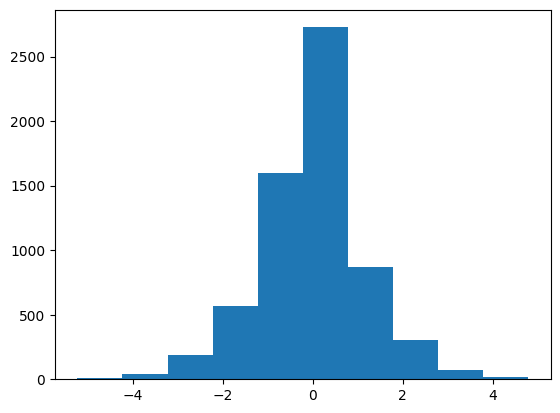

In [55]:
plt.hist(hpreact.detach().numpy().flatten());

- Problem arises when we try to do inference for a single example
  - how to compute mean/std?
  - instead: compute statistics once for the whole (train)dataset (after training)
  - works, but is a bit annoying


In [61]:
with torch.no_grad():
    emb = C[Xtr] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer

    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact_mean = hpreact.mean(dim=0, keepdim=True)
    hpreaact_std = hpreact.std(dim=0, keepdim=True)

In [62]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss_bn_global_statistics(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer

  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  standardized = (hpreact - hpreact_mean) / hpreaact_std
  hpreact = (standardized * bn_gain) + bn_bias

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, y) # loss function
  print(split, loss.item())

split_loss_bn_global_statistics('train')
split_loss_bn_global_statistics('val')

train 2.161442518234253
val 2.1901590824127197


  - instead #2:
    - compute mean and std for each batch during training
    - keep running mean/std
      - .999*running + .001*batch
      - no_grad

In [65]:
(C,W1,b1,W2,b2), g = init_net()

W1.data *= init_factor
b1.data *= 0.01
b2.data *= 0
W2.data *= .01
bn_gain = torch.ones((1, 200), requires_grad=True)
bn_bias = torch.zeros((1, 200), requires_grad=True)


lossi = []
parameters = [C,W1,b1,W2,b2, bn_gain, bn_bias]
max_steps = 50000
batch_size = 32

hpreact_mean = torch.zeros((1, n_hidden))
hpreact_std = torch.ones((1, n_hidden))
momentum = .001

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation

    ########## Batch Norm Magic ############
    with torch.no_grad():
        hpreact_mean = (1-momentum) *  hpreact_mean + momentum * hpreact.mean(dim=0, keepdim=True)
        hpreact_std = (1-momentum) *  hpreact_std + momentum * hpreact.std(dim=0, keepdim=True)

    standardized = (hpreact - hpreact_mean) / hpreact_std
    hpreact = (standardized * bn_gain) + bn_bias

    ########################################


    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

11897
      0/  50000: 3.3179
  10000/  50000: 2.1151
  20000/  50000: 2.2630
  30000/  50000: 2.5377
  40000/  50000: 1.9228


  - compare #1 against #2. Should be close
  - re-run training, should be close


In [66]:
split_loss_bn_global_statistics('train')
split_loss_bn_global_statistics('val')

train 2.219170331954956
val 2.2638094425201416


- Biase b1 is obsolete now, because batch normalization substracts it right away

Continue at "Lecture summarization"